# Imports

In [322]:
import tensorflow as tf
from math import sqrt
import numpy as np
import random
import sys, os
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
import keras.losses
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization
from keras.applications import MobileNetV2
from keras.preprocessing import image_dataset_from_directory
import subprocess, os, shutil


from keras.utils.np_utils import to_categorical   
import subprocess, os, shutil

In [323]:
N_CLASSES=10

# Mounting drive

In [324]:
import subprocess, os, shutil
subprocess.run(['apt-get', 'install', 'unzip'])

CompletedProcess(args=['apt-get', 'install', 'unzip'], returncode=0)

In [325]:
#from google.colab import drive
#drive.mount('drive')

In [326]:
for folder in ['itl_dataset', 'output_proper', 'output_bbox', 'output_proper', 'output_color']:
  if os.path.exists(folder):
    shutil.rmtree(folder)
print(os.getcwd())
VERSION=8
subprocess.run(['wget', f'http://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v{VERSION}.zip'])
subprocess.run(['unzip', f'itl_dataset_v{VERSION}.zip'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

/content


CompletedProcess(args=['unzip', 'itl_dataset_v8.zip'], returncode=1)

# Loading data

In [327]:
import json
with open('annotations.json', 'r') as flabels:
  annots = json.load(flabels)

with open('config/operators.json', 'r') as operatorsfile:
  operators = json.load(operatorsfile)

annots = list(filter(lambda x: len(x['exprs']) != 0, annots))



In [328]:
print(len(annots))
valid_annots = annots[5900:]
annots = annots[:5900]

6127


In [329]:
from keras.utils.np_utils import to_categorical   

op_labels = {j: to_categorical(i, num_classes=N_CLASSES) for i, j in enumerate(operators.keys())}
rev_operators = {i: j for i, j in enumerate(operators.keys())}
op_operators = {k : operators[k]['operands'] for k in operators.keys() }

print(op_labels)
print(rev_operators)
print(op_operators)


{'add': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'sub': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'mul': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'frac': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32), 'sqrt': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32), 'int': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32), 'par': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32), 'fpar': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32), 'ffpar': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32), 'gpar': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)}
{0: 'add', 1: 'sub', 2: 'mul', 3: 'frac', 4: 'sqrt', 5: 'int', 6: 'par', 7: 'fpar', 8: 'ffpar', 9: 'gpar'}
{'add': 2, 'sub': 2, 'mul': 2, 'frac': 2, 'sqrt': 1, 'int': 1, 'par': 1, 'fpar': 1, 'ffpar': 1, 'gpar': 1}


In [330]:
POINTS_PER_BOX=4
INPUT_SHAPE=(224, 224, 1)
N_CLASSES = len(op_labels)

In [331]:



def get_ds_shape(annots, operators):
  possible_operands = sorted([
      operators[k]['operands'] for k in operators.keys()
  ])

  print(possible_operands)

  ds_shape =  {
      operands_no: 0 for operands_no in possible_operands
  }

  for a in annots:
    ds_shape[op_operators[a['op']]]+=1

  return ds_shape, possible_operands


ds_shape, possible_operands = get_ds_shape(annots, operators)
valid_ds_shape, valid_possible_operands = get_ds_shape(valid_annots, operators)

print(ds_shape, valid_ds_shape)

[1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
[1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
{1: 1781, 2: 4119} {1: 65, 2: 162}


In [332]:
def get_datasets(ds_shape, annots):
  datasets = {
      i: {
          'operators': np.zeros((N, N_CLASSES)),
          'bboxes': np.zeros((N, i, POINTS_PER_BOX)),
          'paths': [None] * N,
          'size': 0
      } for i, N in ds_shape.items()
  }

  for j, a in enumerate(annots):
    idx = int(a['name'][len('eq') : a['name'].find('.')])
    operands_type = op_operators[a['op']]
    #assert(j == idx)

    idx = datasets[operands_type]['size']
    datasets[operands_type]['size']+=1

    datasets[operands_type]['operators'][idx] = op_labels[a['op']]

    for k in range(len(a['exprs'])):
        datasets[operands_type]['bboxes'][idx][k] = np.array(a['exprs'][k])

    datasets[operands_type]['paths'][idx] = os.path.join('output_proper', a['name'])
    

  return datasets


def merge_datasets(dataset_list, operands):
  assert(operands == sorted(operands))

  return {
      'operators': np.concatenate([dataset_list[j]['operators'] for j in operands]),
          'bboxes': None, # not used in merged
          'paths': sum((dataset_list[j]['paths'] for j in operands), []),
          'size': sum(dataset_list[j]['size'] for j in operands)
  }

In [333]:
datasets = get_datasets(ds_shape, annots)
turbo_dataset = merge_datasets(datasets, possible_operands)

In [334]:
valid_datasets = get_datasets(ds_shape, valid_annots)
valid_turbo_dataset = merge_datasets(datasets, possible_operands)

In [335]:
from google.colab.patches import cv2_imshow

def load_img(path):
  return 255-cv2.cvtColor(imread(path), cv2.COLOR_BGR2GRAY).reshape(INPUT_SHAPE)

In [336]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
from keras.utils import Sequence

class ITLSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        return np.array([
            load_img(file_name) for file_name in batch_x], dtype=np.float64), batch_y


class ITLSequenceBox(Sequence):
    def __init__(self, paths, bboxes, batch_size, bboxes_no):
        self.x = paths
        
        boxes = bboxes.copy()

        #boxes[..., 2:] **= 2
        #boxes[..., ::2] /= INPUT_SHAPE[0]
        #boxes[..., 1::2] /= INPUT_SHAPE[1]
        self.y = boxes.reshape((-1, bboxes_no*POINTS_PER_BOX))
        
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        return np.array([
            load_img(file_name) for file_name in batch_x], dtype=np.float64), batch_y



In [337]:
def restore_scale(p):
  return (p[0] * INPUT_SHAPE[0], p[1] * INPUT_SHAPE[1], (p[2] * INPUT_SHAPE[0]), (p[3] * INPUT_SHAPE[1]))


def restore_scale2(p):
  return (p[0], p[1], p[2], p[3])

In [338]:
annots[0]

{'exprs': [[18, 91, 86, 40], [119, 101, 84, 19]],
 'label': '\\int f\\left(y-8\\right) \\cdot f\\left(3c \\cdot \\left(bc\\right)\\right)',
 'name': 'eq0.png',
 'op': 'mul'}

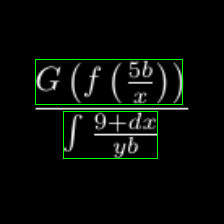

In [339]:
def show_input(dataset, i):
    cv2img = load_img(dataset['paths'][i])
    cv2img = cv2.cvtColor(cv2img, cv2.COLOR_GRAY2BGR)
    for x, y, dx, dy in dataset['bboxes'][i]:
        cv2.rectangle(cv2img, (int(x), int(y)), (int(x+dx), int(y+dy)), [0,255, 0], 1)
    cv2_imshow(cv2img)  

show_input(datasets[2], 2001)

In [340]:
itlseq = ITLSequence(turbo_dataset['paths'], turbo_dataset['operators'], 64)
valid_itlseq = ITLSequence(valid_turbo_dataset['paths'], valid_turbo_dataset['operators'], 64)

BOXES_SUPPORTED=2
bbox_seq = ITLSequenceBox(datasets[BOXES_SUPPORTED]['paths'], datasets[BOXES_SUPPORTED]['bboxes'], 64, BOXES_SUPPORTED)
valid_bbox_seq = ITLSequenceBox(valid_datasets[BOXES_SUPPORTED]['paths'], valid_datasets[BOXES_SUPPORTED]['bboxes'], 64, BOXES_SUPPORTED)

In [341]:
print(len(op_labels))

10


# Model


In [342]:
from pdb import set_trace
import tensorflow as tf

def get_model_operator(verbose=False):
    model = tf.keras.applications.MobileNetV2(weights=None, classes=len(op_labels), input_shape=INPUT_SHAPE)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def get_model_box(boxes_no, verbose=False):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(boxes_no*4))

    model.summary()
    model.compile('adam', 'mse')
    return model

def get_model_box2138(boxes_no, verbose=False):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(boxes_no*4))

    model.summary()
    model.compile('adam', 'mse')
    return model

def get_model_box2137(boxes_no, verbose=False):
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(128))
    model.add(Dense(256))
    model.add(Dropout(0.25))
    model.add(Dense(boxes_no*4))

    model.summary()
    model.compile('adam', 'mse')
    return model

def get_model_box2(boxes_no, verbose=False):
    model = Sequential()   
    model.add(tf.keras.applications.MobileNetV2(weights=None, include_top=False, input_shape=INPUT_SHAPE)) 
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(boxes_no*4))

    if verbose:
      model.summary()

    model.compile('adam', 'mse')

    return model

def get_model_box10(boxes_no, verbose=False):
    model = Sequential()   
    model.add(tf.keras.applications.ResNet50V2(weights=None, include_top=False, input_shape=INPUT_SHAPE)) 
    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(boxes_no*4))

    if verbose:
      model.summary()

    model.compile('adam', 'mse')

    return model

def get_model_box3(boxes_no, verbose=False):
    model = Sequential()
    model.add(tf.keras.applications.MobileNetV2(weights=None, include_top=False, input_shape=INPUT_SHAPE)) 
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(boxes_no*4))

    model.summary()
    model.compile('adam', 'mse')
    return model


def get_model_box4(boxes_no, verbose=False):
    model = Sequential()
    model.add(tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=INPUT_SHAPE)) 
    model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=INPUT_SHAPE))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(boxes_no*4))

    model.summary()
    model.compile('adam', 'mse')
    return model

In [343]:
mdl = get_model_operator()

In [344]:
#mdl.fit(x=itlseq, batch_size=64, epochs=1)
print(datasets[BOXES_SUPPORTED]['paths'][:2])

['output_proper/eq0.png', 'output_proper/eq1.png']


In [345]:
bmdl2 = get_model_box10(BOXES_SUPPORTED)

In [347]:
bmdl2.fit(x=bbox_seq, batch_size=64, epochs=32)

Epoch 1/32
65/65 [==============================] - 35s 541ms/step - loss: 581.5089
Epoch 2/32
65/65 [==============================] - 36s 552ms/step - loss: 251.5692
Epoch 3/32
65/65 [==============================] - 36s 560ms/step - loss: 126.7505
Epoch 4/32
65/65 [==============================] - 37s 563ms/step - loss: 86.5983
Epoch 5/32
65/65 [==============================] - 37s 568ms/step - loss: 59.9748
Epoch 6/32
65/65 [==============================] - 37s 572ms/step - loss: 49.2544
Epoch 7/32
65/65 [==============================] - 37s 575ms/step - loss: 44.0340
Epoch 8/32
65/65 [==============================] - 38s 578ms/step - loss: 30.7930
Epoch 9/32
65/65 [==============================] - 38s 580ms/step - loss: 21.2036
Epoch 10/32
65/65 [==============================] - 38s 582ms/step - loss: 19.3649
Epoch 11/32
65/65 [==============================] - 38s 583ms/step - loss: 35.9779
Epoch 12/32
65/65 [==============================] - 38s 583ms/step - loss: 35.464

In [351]:
import cv2
from google.colab.patches import cv2_imshow
def visualize(path, idx, model):
  infer = load_img(path)
  cv2img = load_img(path)
  cv2_imshow(cv2img)
  cv2img=cv2.cvtColor(cv2img, cv2.COLOR_GRAY2BGR)
  batch = np.zeros((1,*INPUT_SHAPE), dtype=np.float64)
  batch[0] = infer
  points=model.predict_on_batch(batch)[0]
  predicted_boxes_no = len(points) / POINTS_PER_BOX
  print(points)
  def draw_rect(x,y,dx,dy):
    cv2.rectangle(cv2img, (int(x), int(y)), (int(x+dx), int(y+dy)), [0,0,255], 3)

  for j in range(0, len(points), POINTS_PER_BOX):
    x,y,dx,dy = restore_scale2((points[j], points[j+1], points[j+2], points[j+3]))
    draw_rect(x,y,dx,dy)

  print(idx)
  cv2_imshow(cv2img)




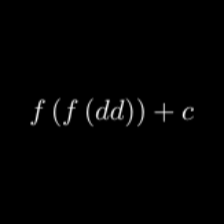

[ 29.526815  98.08056  115.78334   30.94291  183.31418  105.94699
  13.468328  17.367117]
0


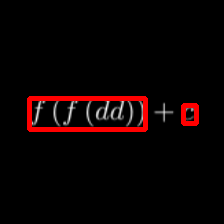

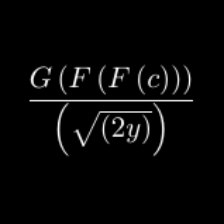

[ 30.09494   64.891205 160.38712   32.621483  55.428658 103.29736
 113.895355  52.737312]
1


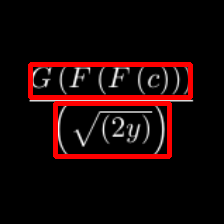

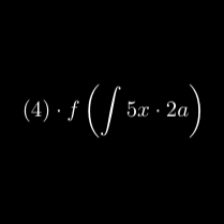

[ 23.72078  100.8065    25.159126  23.506348  68.36476   86.0618
 133.44678   53.394115]
2


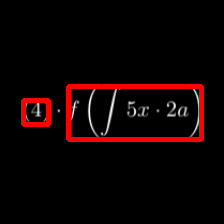

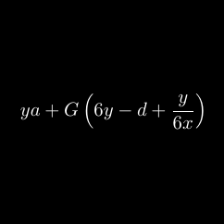

[ 19.732887 105.74279   21.168802  14.591691  66.65664   93.18826
 137.86281   38.26008 ]
3


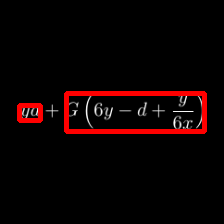

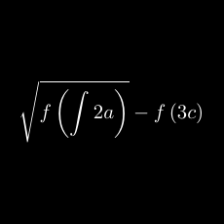

[ 19.468199  82.27308  108.872635  62.362545 156.56142  104.26771
  48.23401   22.362394]
4


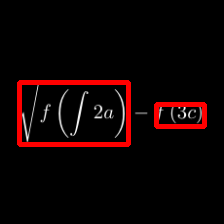

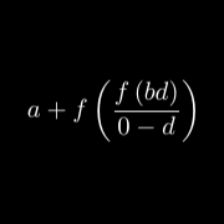

[ 26.782696 103.513084  12.90429   16.339205  73.89973   80.430725
 122.7399    62.20866 ]
5


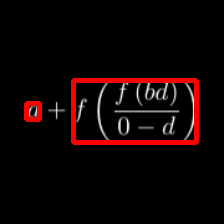

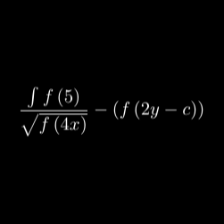

[ 20.563961  87.020706  67.74429   51.37491  114.90374  102.7888
  89.83892   19.831566]
6


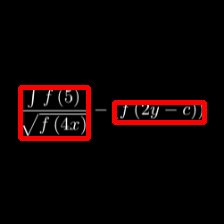

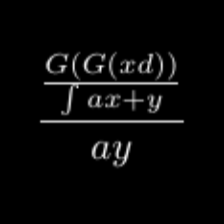

[ 43.43296   49.95337  131.51646   65.43872   90.7076   130.57475
  40.12708   39.991966]
7


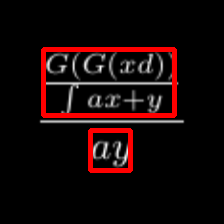

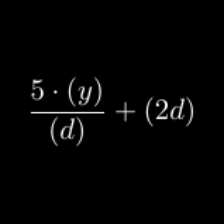

[ 29.469643  77.04191   78.21159   70.613625 147.37555   98.43098
  47.866314  30.340324]
8


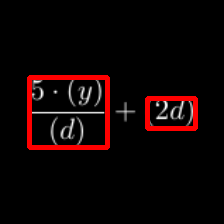

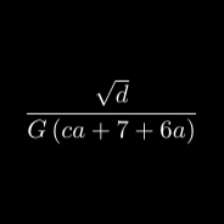

[ 27.409264 117.50704  168.29465   25.801298  95.09291   80.53495
  33.216534  26.228249]
9


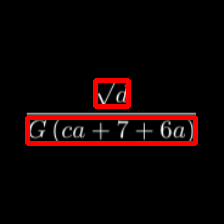

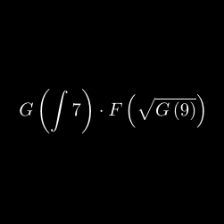

[ 19.080511  88.436424  71.67323   46.623844 110.57667   95.06278
  94.33594   34.260376]
10


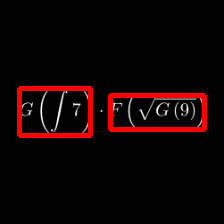

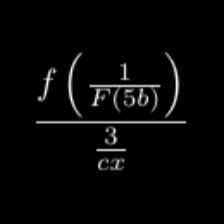

[ 36.474537  50.926125 140.45784   69.79402   97.041336 141.42558
  26.907598  29.083666]
11


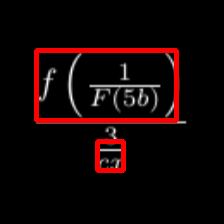

In [352]:
for j in range(12):
  visualize(valid_datasets[BOXES_SUPPORTED]['paths'][j], j, bmdl2)

In [350]:
#mdl.save('itl_op')